# Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City is home to nearly 18.5 million people in 2020, the immigrant population of New York is nearly 3.1m. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great Indian Restaurants and which areas have a scope to open new Indian Restaurants.

# Data


Data For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. Data source : https://cocl.us/new_york_dataset Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city. Indian resturants in each neighborhood of new york city. Data source : Fousquare API Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only Indian restaurants. GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

# Approach

    * Collect the new york city data from https://cocl.us/new_york_dataset
    * Using FourSquare API we will find all venues for each neighborhood.
    * Filter out all venues that are Indian Resturants.
    * Find rating , tips and like count for each Indian Resturants using FourSquare API.
    * Using rating for each resturant , we will sort that data.
    * Visualize the Ranking of neighborhoods using folium library(python)
    

# Queries that can be answered using above dataset

    * What is best location in New York City for Indian Cuisine ?
    * Which areas have potential Indian Restaurant Market ?
    * Which all areas lack Indian Restaurants ?
    * Which is the best place to stay if I prefer Indian Cuisine ?
    
# Analysis
## Required Libraries
    * pandas and numpy for handling data.
    * request module for using FourSquare API.
    * geopy to get co-ordinates of City of New York.
    * folium to visualize the results on a map

In [1]:
!pip install folium
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
#import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

#define some variables
CLIENT_ID = 'NI5U2VE4GUF5XHMSOJKTF50YKQ5XF121TSNPAU1BKP5UCROF' # changed my Foursquare ID
CLIENT_SECRET = 'FIFFIV4BUHRV1T53RCG22P5ZH3SRXHMXQ0URGKEHVJ5DLR2V' # changed Foursquare Secret
VERSION = '20180605' # Foursquare API version

     |████████████████████████████████| 94 kB 6.4 MB/s  eta 0:00:01
Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [20]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
   # CLIENT_ID = 'NI5U2VE4GUF5XHMSOJKTF50YKQ5XF121TSNPAU1BKP5UCROF' # changed my Foursquare ID
    #CLIENT_SECRET = 'FIFFIV4BUHRV1T53RCG22P5ZH3SRXHMXQ0URGKEHVJ5DLR2V' # changed Foursquare Secret
    #VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
   # print("URL is : " + url)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
        
   # CLIENT_ID = '###########################' # i have changed the id with ##
   # CLIENT_SECRET = '############################' # i have changed the secret with ##
   # VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
   # print("Hello")
   # print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [6]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
new_york_data.shape

(306, 4)

In [8]:
print("The number of neighborhoods in NewYork are" , new_york_data.shape[0])

The number of neighborhoods in NewYork are 306


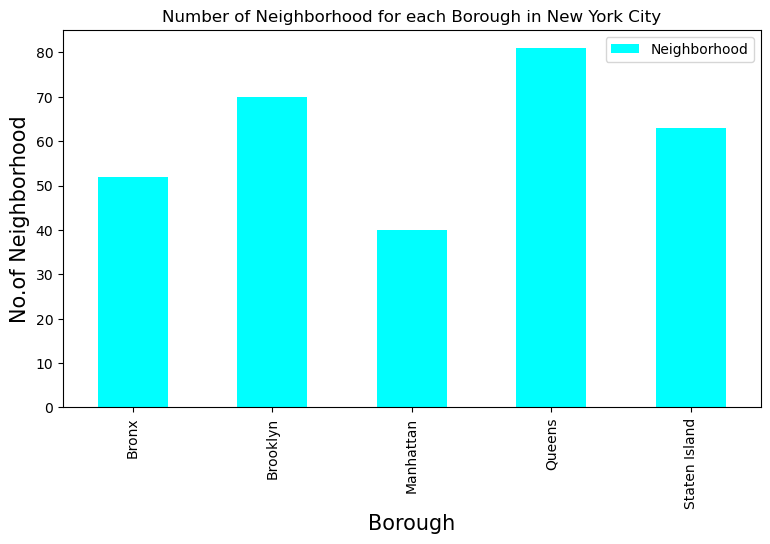

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar',color="cyan")
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will find all Indian resturants for each Neighborhood.

In [23]:
# Prepare list of all Indian Retaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
tot_rest = 0
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']
    if len(indian_resturants) > 0:
       # print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
        print('Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
        for resturant_detail in indian_resturants.values.tolist():
            id, name , category=resturant_detail
            indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
   # count+=1
    tot_rest = tot_rest + len(indian_resturants)
print('Total Number of Indian Restaurants in New YorK is : ', tot_rest)

Indian Resturants in Woodlawn, Bronx:1
Indian Resturants in Parkchester, Bronx:1
Indian Resturants in Spuyten Duyvil, Bronx:1
Indian Resturants in Concourse, Bronx:1
Indian Resturants in Unionport, Bronx:1
Indian Resturants in Bay Ridge, Brooklyn:2
Indian Resturants in Brighton Beach, Brooklyn:1
Indian Resturants in Flatbush, Brooklyn:2
Indian Resturants in East Flatbush, Brooklyn:1
Indian Resturants in Kensington, Brooklyn:2
Indian Resturants in Fort Greene, Brooklyn:1
Indian Resturants in Clinton Hill, Brooklyn:2
Indian Resturants in Prospect Lefferts Gardens, Brooklyn:2
Indian Resturants in Ocean Hill, Brooklyn:1
Indian Resturants in Prospect Park South, Brooklyn:2
Indian Resturants in East Williamsburg, Brooklyn:1
Indian Resturants in Fort Hamilton, Brooklyn:1
Indian Resturants in Washington Heights, Manhattan:1
Indian Resturants in Hamilton Heights, Manhattan:2
Indian Resturants in Manhattanville, Manhattan:2
Indian Resturants in Central Harlem, Manhattan:2
Indian Resturants in Ea

KeyError: 'groups'

In [11]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


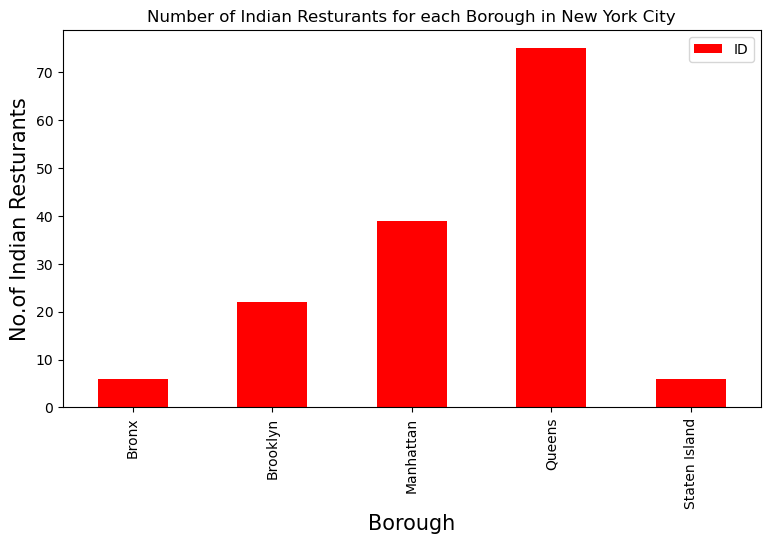

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar',color='red')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of indian resturants

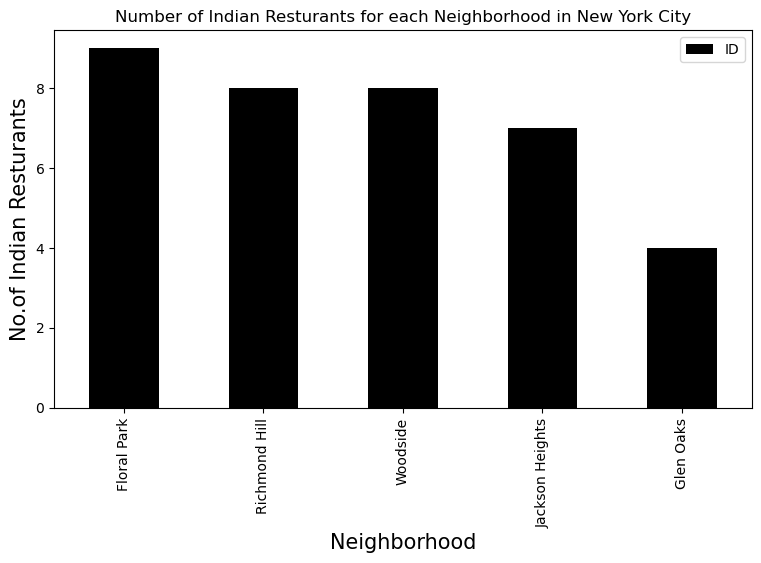

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar',color="black")
#legend
plt.legend()
#displays the plot
plt.show()

So the Neighborhood Floral Park has maximum number of Indian Restaurants, Now lets list them

In [14]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
105,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
106,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
107,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
108,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
109,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
110,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
111,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
112,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
113,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


So Floral Park in Queens has the highest number of Indian Resturants with a total count of 9.

Now we will get the ranking of each resturant for further analysis.

In [17]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    print("ID" ,ID )
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

ID 4c0448d9310fc9b6bf1dc761
Hello
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '605c39f30eee4657d6baba3a'}, 'response': {}}


KeyError: 'venue'

In [24]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips


In [25]:
indian_rest_stats_ny.shape

(0, 7)

In [ ]:
indian_rest_ny.shape

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [ ]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [ ]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.shape

In [ ]:
indian_rest_stats_ny_csv.head()

In [ ]:
indian_rest_stats_ny.info()

We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [ ]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

Now the data types looks correct

In [ ]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

In [ ]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

In [ ]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

In [ ]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Above are the top neighborhoods with top average rating of Indian resturant

In [ ]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Similarly these are the average rating of Indian Resturants for each Borough

Lets visualize it

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar',color='pink')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

ny_neighborhood_stats

We will join this dataset to original new york data to get lonitude and latitude

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

Now we will show this data on a map

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods. Lets Visualize Boroughs based on average Rating

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'boroughBoundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')